In [2]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import aesara.tensor as at 
random_seed = 42
DATA_URL = "https://raw.githubusercontent.com/fonnesbeck/probabilistic_python/master/data/"

In [3]:
spin_rate_data = pd.read_csv(DATA_URL + "savant_data.csv",parse_dates=["game_date"]).dropna(subset=["spin_rate","game_date"])

spin_rate_data.head()

,pitches,player_id,player_name,game_date,total_pitches,pitch_percent,ba,iso,babip,slg,...,takes,eff_min_vel,release_extension,pos3_int_start_distance,pos4_int_start_distance,pos5_int_start_distance,pos6_int_start_distance,pos7_int_start_distance,pos8_int_start_distance,pos9_int_start_distance
0,47,450203,"Morton, Charlie",2021-07-16,107,43.9,0.077,0.077,0.167,0.154,...,28,0.1,6.36,111.0,148.0,139.0,134.0,299.0,320.0,300.0
1,47,621244,"Berríos, José",2021-05-08,104,45.2,0.143,0.286,0.143,0.429,...,28,-0.2,6.31,101.0,148.0,112.0,145.0,295.0,332.0,297.0
2,46,450203,"Morton, Charlie",2021-06-17,112,41.1,0.000,0.000,0.000,0.000,...,20,-0.4,6.21,105.0,151.0,134.0,137.0,314.0,322.0,291.0
3,45,450203,"Morton, Charlie",2021-08-31,106,42.5,0.100,0.000,0.143,0.100,...,26,-0.4,6.16,114.0,153.0,139.0,143.0,296.0,317.0,298.0
4,45,450203,"Morton, Charlie",2021-06-22,107,42.1,0.000,0.000,NaN,0.000,...,27,-0.8,6.28,107.0,149.0,135.0,135.0,290.0,304.0,291.0


<Axes: xlabel='game_date', ylabel='spin_rate'>

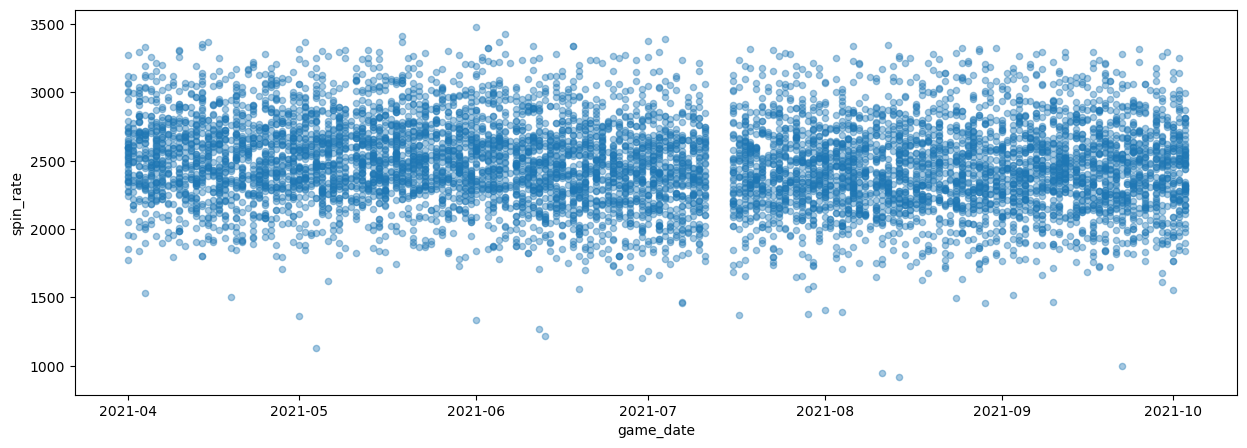

In [4]:
spin_rate_data.plot.scatter(x="game_date",y="spin_rate",figsize=(15,5),alpha=0.4)

In [5]:
day_ind, date = pd.factorize(spin_rate_data.game_date,sort=True)
spin_rate= spin_rate_data.spin_rate.values

print(day_ind)
print(date)

[102  37  77 ...  77  44 163]
DatetimeIndex(['2021-04-01', '2021-04-02', '2021-04-03', '2021-04-04',
               '2021-04-05', '2021-04-06', '2021-04-07', '2021-04-08',
               '2021-04-09', '2021-04-10',
               ...
               '2021-09-24', '2021-09-25', '2021-09-26', '2021-09-27',
               '2021-09-28', '2021-09-29', '2021-09-30', '2021-10-01',
               '2021-10-02', '2021-10-03'],
              dtype='datetime64[ns]', length=182, freq=None)


rt = u1 if t < tao 

rt = u2 if t >tao

tao is the day in the season when the rule was implementes


y = pitch speed rate

y_i(pre) = Normal(u_1, sigma)

y_i(post) = Normal(u_2,sigma)

we want to find tao

### We assume the following prior distributions:

u_i = Normal(2500,100)

tao = Uniform(0,T)

sigma = HalfNormal(100)

### Implementation

In [6]:
with pm.Model() as spin_rate_model:

    mu = pm.Normal("mu",mu=2500, sigma=100, shape=2)
    tau = pm.Uniform("tau",lower=day_ind.min(),upper=day_ind.max())


In [7]:
pm.logp(tau,5).eval()

array(-5.19849703)

In [8]:
pm.draw(mu,5)

array([[2561.6542241 , 2590.62885512],
       [2500.14855842, 2406.06828207],
       [2459.27993432, 2446.51649212],
       [2499.48774759, 2615.49053788],
       [2522.46307585, 2437.55776883]])

In [9]:
with spin_rate_model:
    sigma = pm.HalfNormal("sigma",100.)

In [10]:
spin_rate_model.unobserved_RVs

[mu ~ Normal(2.5e+03, 100), tau ~ Uniform(0, 181), sigma ~ HalfNormal(0, 100)]

c:\Users\aleja\.conda\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

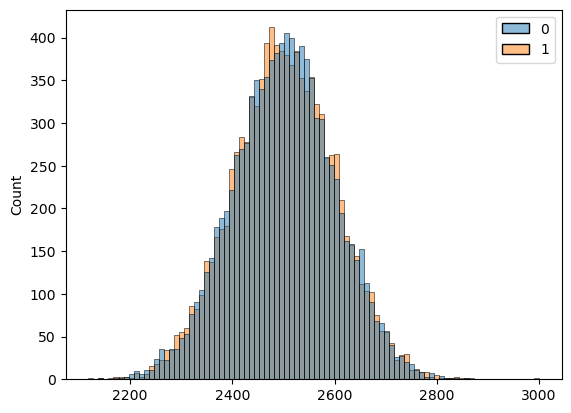

In [12]:
sns.histplot(pm.draw(mu,10000))

### Deterministic variables

In [13]:
with spin_rate_model:
    r = pm.math.switch(tau>= day_ind,mu[0],mu[1])
    

In [14]:
with spin_rate_model:

    spin_rate_like = pm.Normal("spin_rate_like",mu=r, sigma = sigma,observed=spin_rate)

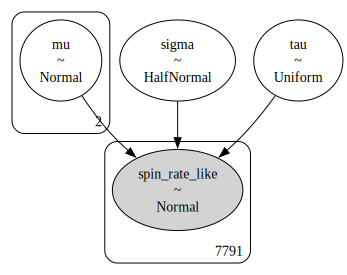

In [38]:
pm.model_to_graphviz(spin_rate_model)

In [40]:
with spin_rate_model:
    trace = pm.sample()

c:\Users\aleja\.conda\envs\pymc_env\Lib\site-packages\multipledispatch\dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 863 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [16]:
az.plot_posterior(trace,var_names=["mu","tau"])

NameError: name 'trace' is not defined

<xarray.Dataset>
Dimensions:   (chain: 4, draw: 1000, mu_dim_0: 2)
Coordinates:
  * chain     (chain) int32 0 1 2 3
  * draw      (draw) int32 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * mu_dim_0  (mu_dim_0) int32 0 1
Data variables:
    mu        (chain, draw, mu_dim_0) float64 2.499e+03 2.434e+03 ... 2.438e+03
    tau       (chain, draw) float64 77.58 77.15 77.19 77.5 ... 67.39 67.41 67.09
    sigma     (chain, draw) float64 317.3 317.4 317.4 ... 315.2 315.6 313.3
Attributes:
    created_at:                 2024-01-07T14:56:25.505263
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.3
    sampling_time:              863.3394780158997
    tuning_steps:               1000


In [15]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] ="1"
with spin_rate_model:
    trace = pm.sample()

c:\Users\aleja\.conda\envs\pymc_env\Lib\site-packages\multipledispatch\dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [

KeyboardInterrupt: 